In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
sns.set_theme(style="whitegrid")

path = '.'
csvList = os.listdir(path)
csvList = [item for item in csvList if item.endswith('.csv')]
print(csvList)


['accounts_0.csv', 'accounts_1.csv', 'accounts_2.csv', 'accounts_3.csv', 'accounts_4.csv', 'transactions_0.csv', 'transactions_1.csv', 'transactions_2.csv', 'transactions_3.csv', 'transactions_4.csv']


## Some basic Pre-processing

In [3]:
accountCSVs = [item for item in csvList if item.startswith('accounts')]
accountDFs = [pd.read_csv(item) for item in accountCSVs]
transactionCSVs = [
    item for item in csvList if item.startswith('transactions')]
transactionDFs = [pd.read_csv(item) for item in transactionCSVs]

for df in transactionDFs:
    df.tran_timestamp = pd.to_datetime(df.tran_timestamp)


<AxesSubplot:xlabel='orig_acct', ylabel='Density'>

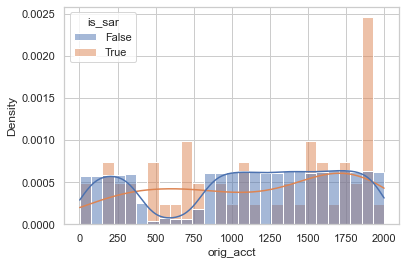

In [4]:
sns.histplot(data=transactionDFs[0], x='orig_acct', hue='is_sar',
             stat='density', common_norm=False, kde=True)


False    13060
True        55
Name: is_sar, dtype: int64


Text(0.5, 1.0, 'Data Imbalance')

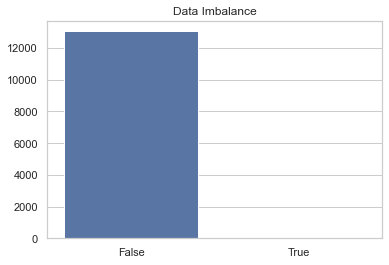

In [5]:
x = transactionDFs[0]['is_sar'].value_counts().index
y = transactionDFs[0]['is_sar'].value_counts().values
print(transactionDFs[0]['is_sar'].value_counts())
ax = sns.barplot(x=x, y=y)
ax.set_title('Data Imbalance')


# Use case: Aggregate Statistics

## Individual FI Monitoring

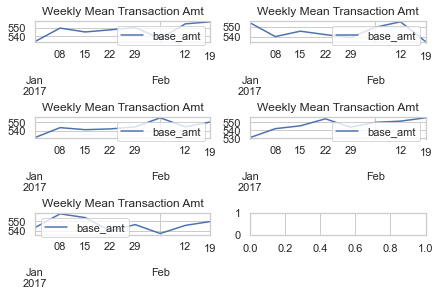

In [6]:

fig, axes = plt.subplots(nrows=3, ncols=2, constrained_layout = True)
plt.rcParams["figure.figsize"] = (7, 6)
plt.rcParams['figure.dpi'] = 100
for df, i in zip(transactionDFs, range(len(transactionDFs))):
    df.groupby(pd.Grouper(key='tran_timestamp', freq='1W')).mean()[['base_amt']].plot(title = 'Weekly Mean Transaction Amt', ax = axes[math.floor(i/2), i%2], xlabel = "")




## Aggregate FI Monitoring

<AxesSubplot:title={'center':'System-Wide Weekly Mean Transaction Amt'}, xlabel='tran_timestamp'>

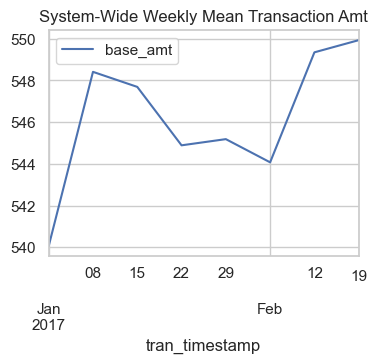

In [7]:
aggDF = pd.concat(transactionDFs)
plt.rcParams["figure.figsize"] = (4, 3)
aggDF.groupby(pd.Grouper(key='tran_timestamp', freq='1W')).mean()[
    ['base_amt']].plot(title='System-Wide Weekly Mean Transaction Amt')


# AR(p) Model 

<AxesSubplot:title={'center':'System-Wide Weekly Sum Transaction Amt'}, xlabel='tran_timestamp'>

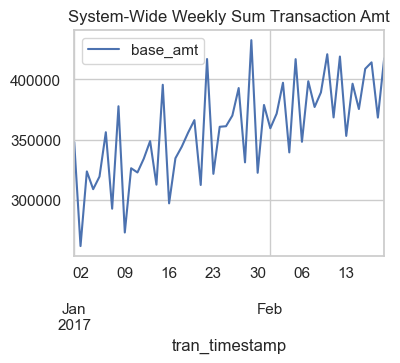

In [8]:
aggDF = pd.concat([transactionDFs[4]])
plt.rcParams["figure.figsize"] = (4, 3)
aggDF.groupby(pd.Grouper(key='tran_timestamp', freq='1D')).sum()[
    ['base_amt']].plot(title='System-Wide Weekly Sum Transaction Amt')


In [9]:
values = aggDF.groupby(pd.Grouper(key='tran_timestamp', freq='1D'))[['base_amt']].sum()
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe
result = dataframe.corr()

print(result)


          base_amt  base_amt
base_amt  1.000000  0.057335
base_amt  0.057335  1.000000


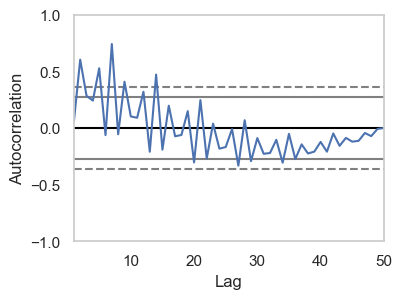

In [10]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(values)
plt.show()


In [12]:
from pandas import read_csv
from matplotlib import pyplot
import statsmodels



In [13]:
from sklearn import linear_model
predictsize = 10
x, y = pd.concat([values.shift(2), values.shift(1)],
                 axis=1).iloc[2:-predictsize], values.iloc[2:-predictsize]
x_test, y_test = pd.concat([values.shift(2), values.shift(1)],
                           axis=1).iloc[-predictsize:], values.iloc[-predictsize:]
regr = linear_model.LinearRegression(fit_intercept=False)
regr.fit(x, y)
y_predict = regr.predict(x_test)


Coefficients: 
 [[0.80770746 0.20108901]]
Mean squared error: 665581767.70
Coefficient of determination: -0.13


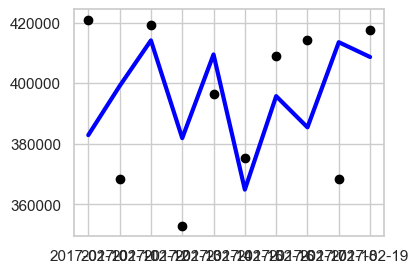

In [14]:
from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" %
      mean_squared_error(y_test, y_predict))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" %
      r2_score(y_test, y_predict))

# Plot outputs
plt.scatter(x = x_test.index,y = y_test, color="black")
plt.plot(x_test.index, y_predict, color="blue", linewidth=3)


plt.show()


In [15]:
transactionDFs[0].head()

,tran_id,orig_acct,bene_acct,tx_type,base_amt,tran_timestamp,is_sar,alert_id
0,4,1033,1655,TRANSFER,483.24,2017-01-01 00:00:00+00:00,False,-1
1,10,1728,8482,TRANSFER,789.81,2017-01-01 00:00:00+00:00,False,-1
2,13,1995,4807,TRANSFER,710.99,2017-01-01 00:00:00+00:00,False,-1
3,15,1103,882,TRANSFER,257.59,2017-01-01 00:00:00+00:00,False,-1
4,16,1299,5961,TRANSFER,576.67,2017-01-01 00:00:00+00:00,False,-1
